In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import lambertw

# --- GLOBAL CONFIGURATION ---
# Network Physics
N_NODES = 1000       # Default node count
K = 5                # Connectivity
NOISE_SCALE = 1.0    # Scale of exponential noise
B_INIT = 1.0         # Initial buffer size
T_STEPS = 2000       # Simulation duration
T_START = 100        # Steps to skip for statistics (transient phase)

# --- PARAMETRI AGGIORNATI PER REALISMO ---
ALPHA = 0.25      # Era 0.5 o 1.0. Abbassalo per reazioni meno "paniche".
EPSILON = 0.02    # Era 0.09. Abbassalo per un risparmio più graduale (discesa dolce).
PIPELINE_LEN = 5  # (Delay) Tienilo a 5. È un buon valore fisico per la latenza.
NOISE_SCALE = 1.0 # (Rumore) Va bene così.

# Per il confronto Myopic vs Wise
BETA_MYOPIC = 0.0
BETA_WISE = 1.0

# Analytical Threshold Calculation (Bc)
# Solves: Bc * exp(1 - Bc) = 1/K
BC_THEO = -lambertw(-1/(np.exp(1)*K), k=-1).real

# --- VISUALIZATION STYLE ---
# Unified Color Palette
COLORS = {
    'SIMULATION': '#2E86AB',  # Deep Blue
    'THEORY': '#A23B72',      # Purple/Magenta
    'MYOPIC': '#F18F01',      # Orange
    'WISE': '#73AB84',        # Green
    'GRID': '#E0E0E0',
    'ZERO': '#666666'
}

print(f"--- CONFIGURATION LOADED ---")
print(f"Connectivity (K): {K}")
print(f"Theoretical Critical Threshold (Bc): {BC_THEO:.4f}")
print(f"Correction Gain (Alpha): {ALPHA}")

--- CONFIGURATION LOADED ---
Connectivity (K): 5
Theoretical Critical Threshold (Bc): 3.9943
Correction Gain (Alpha): 0.25


In [2]:
def simulate_fixed_buffer(B, k, n, T, T_start, noise_scale=1.0):
    """
    Simulates the network with a STATIC buffer to measure delay accumulation velocity (v).
    Used for the Static Analysis plot.
    """
    delays_last = np.zeros(n)
    v_history = []
    
    for t in range(T):
        eps = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        delays_selected = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(delays_last)
            delays_selected[i*n : (i+1)*n] = delays_last
        delays_matrix = np.reshape(delays_selected, (n, k))
        
        total_load = np.max(delays_matrix, axis=1) + eps
        delays_curr = np.maximum(0, total_load - B)
        
        if t >= T_start:
            v_history.append(np.mean(delays_curr - delays_last))
        delays_last = delays_curr
    return np.mean(v_history)


def synthetic_temporal_network_soc(B_start, k, n, T, T_start, epsilon=0.09, alpha=0.1, beta=1.0, pipeline_len=5, noise_scale=1.0):
    """
    Simulates a Synthetic Temporal Network with SOC and PHYSICAL DELAY.
    
    Parameters:
    - pipeline_len: Represents the DELIVERY DELAY (steps between order and arrival).
    - beta: 1.0 = Wise Agent (considers pending orders), 0.0 = Myopic Agent.
    """
    delays_last_iteration = np.zeros(n)
    buffers = np.full(n, B_start)
    
    # SUPPLY CHAIN: Rappresenta gli ordini fisici in viaggio.
    # Shape: (n_nodi, giorni_di_viaggio)
    # La colonna [:, 0] è la merce in arrivo OGGI.
    # La colonna [:, -1] è dove inseriamo i NUOVI ordini.
    supply_chain = np.zeros((n, pipeline_len))
    
    mean_delays = np.zeros(T - T_start)
    mean_buffers = np.zeros(T - T_start)
    
    for t in range(T):
        # --- 1. FISICA: Consegna Merce (Dagli ordini passati) ---
        arriving_resources = supply_chain[:, 0]
        buffers = np.maximum(0, buffers + arriving_resources)
        
        # Shift della catena: tutto avanza di un giorno verso l'arrivo
        supply_chain[:, :-1] = supply_chain[:, 1:]
        supply_chain[:, -1] = 0.0 # Puliamo l'ultimo slot per gli ordini di oggi
        
        # --- 2. DINAMICA: Generazione Carico e Ritardo ---
        eps_noise = scipy.stats.expon.rvs(scale=noise_scale, size=n)
        delays_selected = np.zeros(n * k)
        for i in range(k):
            np.random.shuffle(delays_last_iteration)
            delays_selected[i*n : (i+1)*n] = delays_last_iteration
        delays_matrix = np.reshape(delays_selected, (n, k))
        
        total_incoming_load = np.max(delays_matrix, axis=1) + eps_noise
        
        # Il ritardo attuale (Segnale di errore)
        delays_current = np.maximum(0, total_incoming_load - buffers)
        is_delayed = delays_current > 0.001
        
        # --- 3. CERVELLO DELL'AGENTE (Decisione) ---
        
        # Calcolo ordini pendenti (Quanto ho già ordinato che deve ancora arrivare?)
        # Questo sostituisce la vecchia 'pipeline_memory'
        pending_orders = np.sum(supply_chain, axis=1)
        
        # GAP PERCEPITO:
        # Se Beta=1 (Saggio): Sottrae gli ordini pendenti dal ritardo attuale.
        # Se Beta=0 (Miope): Ignora i pendenti, reagisce al ritardo pieno.
        perceived_gap = delays_current - (beta * pending_orders)
        
        # --- 4. AZIONE ---
        new_orders = np.zeros(n)
        
        # CASO A: C'è Ritardo (o gap percepito positivo) -> ORDINO
        # Nota: L'ordine non cambia il buffer ora! Entra nella supply chain.
        needs_increase = (is_delayed) & (perceived_gap > 0)
        new_orders[needs_increase] = alpha * perceived_gap[needs_increase]
        
        # Inseriamo i nuovi ordini in fondo al tubo (arriveranno tra pipeline_len step)
        supply_chain[needs_increase, -1] = new_orders[needs_increase]
        
        # CASO B: Non c'è Ritardo -> OTTIMIZZO (Decay/Epsilon)
        # Nota: Il taglio dei costi è immediato (es. spengo macchine, attrito naturale)
        # Questo crea l'asimmetria realistica.
        buffers[~is_delayed] = np.maximum(0, buffers[~is_delayed] - epsilon)
        
        # --- 5. DATA LOGGING ---
        if t >= T_start:
            mean_delays[t - T_start] = np.mean(delays_current)
            mean_buffers[t - T_start] = np.mean(buffers)
            
        delays_last_iteration = delays_current
        
    return mean_delays, mean_buffers, delays_last_iteration

In [3]:
def plot_system_breathing():
    """Generates the 'Breathing' Plot: Instantaneous Velocity vs Recovery."""
    print("Generating System Breathing Plot...")
    
    # Run simulation specifically for this plot to get high-res data
    # Note: We need the full delay history, which needs a slight tweak to the core function 
    # OR we re-calculate delays from the mean returned. 
    # For simplicity, we assume the mean_delays returned by the function is sufficient 
    # to show the global system velocity.
    
    mean_delays, _, _ = synthetic_temporal_network_soc(
        B_start=8.0, k=K, n=N_NODES, T=1000, T_start=0, beta=BETA_WISE, alpha=ALPHA
    )

    # Calculate Velocity (Derivative of Delay)
    velocity_instant = np.diff(mean_delays)
    time_axis = range(1, 1000)

    plt.figure(figsize=(14, 6))

    # Zones
    plt.axhspan(0, np.max(velocity_instant), facecolor='#ffbfbf', alpha=0.2, label='Accumulation (v > 0)')
    plt.axhspan(np.min(velocity_instant), 0, facecolor='#c7f9cc', alpha=0.3, label='Recovery (v < 0)')

    # Data
    plt.plot(time_axis, velocity_instant, color=COLORS['SIMULATION'], linewidth=1, alpha=0.8, label='Instantaneous Velocity')
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

    # Moving Average
    def moving_average(a, n=20):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    v_smooth = moving_average(velocity_instant, n=15)
    plt.plot(range(15, 1000), v_smooth, color='blue', linewidth=2.5, label='Trend (MA)')

    plt.title("The SOC System with Local Updates: Accumulation vs Recovery")
    plt.xlabel("Time (Step)")
    plt.ylabel("Global Delay Velocity ($v$)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

In [4]:
def plot_single_run_comparison():
    """
    Generates Plot A: Single Representative Run (COMPARISON).
    Confronta direttamente il comportamento Miope (Arancione) vs Saggio (Verde)
    sotto lo STESSO carico di lavoro.
    """
    print("Generating Plot: Myopic vs Wise Comparison...")
    
    # Parametri specifici per questo plot
    # Assumiamo che BETA_MYOPIC = 0.0 e BETA_WISE = 1.0
    # Assumiamo ALPHA e EPSILON già definiti globalmente o passati qui
    
    # --- 1. SIMULAZIONE MIOPE ---
    # Resettiamo il seed per garantire che il "Carico" sia identico per entrambi
    np.random.seed(42) 
    _, b_myopic, _ = synthetic_temporal_network_soc(
        B_INIT, K, N_NODES, T_STEPS, 0, beta=0.0, alpha=ALPHA, epsilon=EPSILON
    )
    
    # --- 2. SIMULAZIONE SAGGIA ---
    # Resettiamo il seed ALLO STESSO NUMERO. 
    # Così il Wise agent affronta gli stessi identici shock del Miope.
    np.random.seed(42) 
    _, b_wise, _ = synthetic_temporal_network_soc(
        B_INIT, K, N_NODES, T_STEPS, 0, beta=1.0, alpha=ALPHA, epsilon=EPSILON
    )
    
    # --- PLOT ---
    plt.figure(figsize=(12, 6))
    
    # Linea MIOPE (Arancione/Instabile)
    plt.plot(b_myopic, color='#F18F01', linewidth=1.5, alpha=0.7, label='Myopic Agent (No Memory)')
    
    # Linea SAGGIA (Verde/Stabile)
    plt.plot(b_wise, color='#2A9D8F', linewidth=2.0, alpha=0.9, label='Wise Agent (With Memory)')
    
    # Soglia Teorica
    plt.axhline(BC_THEO, color='#800020', linestyle='--', linewidth=2.5, label=f'Theoretical $B_c$ ≈ {BC_THEO:.2f}')
    
    plt.title("Impact of Memory on Buffer Dynamics (Identical Load)", fontsize=14)
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Average Buffer Size", fontsize=12)
    plt.legend(fontsize=11, loc='upper right', framealpha=0.95)
    plt.grid(True, alpha=0.3)
    
    # Aggiungi una nota testuale se vuoi evidenziare la differenza
    plt.tight_layout()
    plt.show()


In [5]:
def plot_static_velocity_comparison():
    """
    Confronta la velocità istantanea nel tempo per due casi:
    1. INSTABILE (B < Bc): Accumulo costante (Velocità media > 0).
    2. STABILE (B > Bc): Equilibrio (Velocità media ≈ 0).
    """
    print("Generazione Grafico: Confronto Velocità Instabile vs Stabile...")
    
    # Parametri
    T_TEST = 1000
    B_UNSTABLE = 2.0  # Sotto la soglia (Instabile)
    B_STABLE = 5.0    # Sopra la soglia (Stabile)
    
    # Funzione interna per simulare
    def run_simulation(buffer_val):
        delays_last = np.zeros(N_NODES)
        v_history = []
        for t in range(T_TEST):
            eps = scipy.stats.expon.rvs(scale=NOISE_SCALE, size=N_NODES)
            delays_selected = np.zeros(N_NODES * K)
            for i in range(K):
                np.random.shuffle(delays_last)
                delays_selected[i*N_NODES : (i+1)*N_NODES] = delays_last
            delays_matrix = np.reshape(delays_selected, (N_NODES, K))
            
            total_load = np.max(delays_matrix, axis=1) + eps
            delays_curr = np.maximum(0, total_load - buffer_val)
            
            # Velocità = Differenza di ritardo
            v_t = np.mean(delays_curr - delays_last)
            v_history.append(v_t)
            delays_last = delays_curr
        return v_history

    # Eseguiamo le due simulazioni
    v_unstable = run_simulation(B_UNSTABLE)
    v_stable = run_simulation(B_STABLE)

    # --- PLOT (2 Subplots) ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # 1. CASO INSTABILE (Rosso)
    axes[0].plot(v_unstable, color='#D62828', linewidth=1, alpha=0.8, label=f'Unstable (B={B_UNSTABLE})')
    mean_unstable = np.mean(v_unstable[100:])
    axes[0].axhline(mean_unstable, color='black', linestyle='--', linewidth=2, label=f'Mean Velocity ≈ {mean_unstable:.2f}')
    
    axes[0].set_title(f"A) Unstable Phase ($B < B_c$) without Local Updates: Constant Accumulation", fontsize=14)
    axes[0].set_ylabel("Velocity ($v_t$)", fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    # Colora lo sfondo per indicare pericolo
    axes[0].set_facecolor('#FFF5F5') 

    # 2. CASO STABILE (Verde)
    axes[1].plot(v_stable, color='#2A9D8F', linewidth=1, alpha=0.8, label=f'Stable (B={B_STABLE})')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=2, label='Equilibrium ($v=0$)')
    
    axes[1].set_title(f"B) Stable Phase ($B > B_c$) without Local Updates: Stationary Equilibrium", fontsize=14)
    axes[1].set_xlabel("Time Steps", fontsize=12)
    axes[1].set_ylabel("Velocity ($v_t$)", fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    # Colora lo sfondo per indicare sicurezza
    axes[1].set_facecolor('#F0FFF4')

    plt.tight_layout()
    plt.show()


In [6]:
def plot_velocity_trend_comparison():
    """
    Confronto dei TREND di velocità.
    CORRETTO: Ora usa la funzione 'synthetic_temporal_network_soc' per garantire
    che la fisica (Supply Chain/Delay) sia identica a quella degli altri grafici.
    """
    print("Generazione Confronto Trend: Statico vs SOC...")
    
    T_SIM = 1500
    B_START = 2.0 
    WINDOW = 50 
    
    # --- 1. DATI STATICI ---
    # Usiamo la tua funzione simulate_fixed_buffer, ma dobbiamo modificarla leggermente
    # per farci restituire la STORIA delle velocità, non solo la media.
    # O più semplicemente, la rifacciamo rapida qui per coerenza.
    def get_static_vel_history():
        delays_last = np.zeros(N_NODES)
        v_hist = []
        for t in range(T_SIM):
            eps = scipy.stats.expon.rvs(scale=NOISE_SCALE, size=N_NODES)
            delays_selected = np.zeros(N_NODES * K)
            for i in range(K):
                np.random.shuffle(delays_last)
                delays_selected[i*N_NODES : (i+1)*N_NODES] = delays_last
            delays_matrix = np.reshape(delays_selected, (N_NODES, K))
            total_load = np.max(delays_matrix, axis=1) + eps
            
            delays_curr = np.maximum(0, total_load - B_START)
            v_hist.append(np.mean(delays_curr - delays_last))
            delays_last = delays_curr
        return v_hist

    vel_static_raw = get_static_vel_history()

    # --- 2. DATI SOC (CORRETTO) ---
    # Chiamiamo la TUA funzione principale corretta!
    # Nota: T_start=0 per avere tutti i dati
    mean_delays_soc, _, _ = synthetic_temporal_network_soc(
        B_start=B_START, k=K, n=N_NODES, T=T_SIM, T_start=0,
        epsilon=EPSILON, alpha=ALPHA, beta=1.0, pipeline_len=PIPELINE_LEN
    )
    
    # Calcolo Velocità SOC: v(t) = Delay(t) - Delay(t-1)
    # Aggiungiamo uno 0 all'inizio per mantenere la lunghezza array
    vel_soc_raw = np.diff(mean_delays_soc, prepend=mean_delays_soc[0])

    # --- 3. Calcolo Media Mobile (Trend) ---
    def moving_average(a, n=WINDOW):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    trend_static = moving_average(vel_static_raw)
    trend_soc = moving_average(vel_soc_raw)
    
    time_ax = range(WINDOW - 1, T_SIM) 

    # --- PLOT ---
    plt.figure(figsize=(12, 6))
    
    # Plot Statico
    plt.plot(time_ax, trend_static, color=COLORS['THEORY'], linewidth=3, label='Static Case ($B=2.0$): Fate is Sealed')
    
    mid_idx = len(trend_static) // 2
    plt.annotate('Constant Accumulation\n(Velocity > 0)', xy=(time_ax[mid_idx], trend_static[mid_idx]), 
                 xytext=(time_ax[mid_idx], trend_static[mid_idx]+0.5), ha='center',
                 arrowprops=dict(facecolor=COLORS['THEORY'], shrink=0.05))

    # Plot SOC
    plt.plot(time_ax, trend_soc, color=COLORS['WISE'], linewidth=3, label='SOC Case (Starts $B=2.0$): Adaptation')
    
    annot_idx = min(400, len(trend_soc)-1)
    plt.annotate('Adaptation -> Equilibrium\n(Velocity drops to 0)', xy=(time_ax[annot_idx], trend_soc[annot_idx]), 
                 xytext=(time_ax[annot_idx]+200, trend_soc[annot_idx]+0.8), ha='center',
                 arrowprops=dict(facecolor=COLORS['WISE'], shrink=0.05))

    plt.axhline(0, color=COLORS['ZERO'], linestyle='--', alpha=0.5)

    plt.title("The Difference: Static Fate vs. SOC Adaptation (Velocity Trend)", fontsize=14)
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Average Velocity (Trend)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, color=COLORS['GRID'])
    plt.tight_layout()
    plt.show()

Generazione Grafico: Confronto Velocità Instabile vs Stabile...


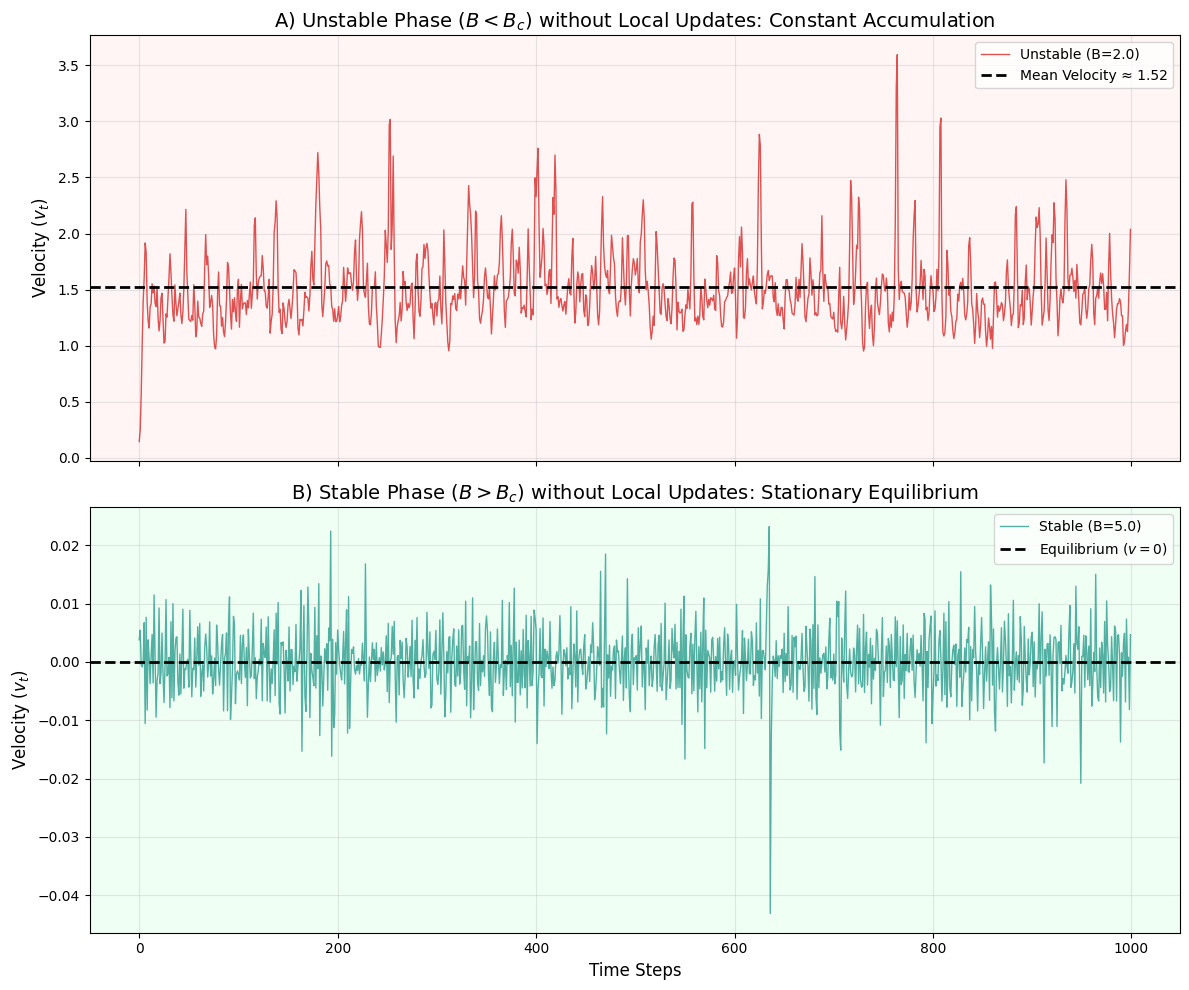

Generazione Confronto Trend: Statico vs SOC...


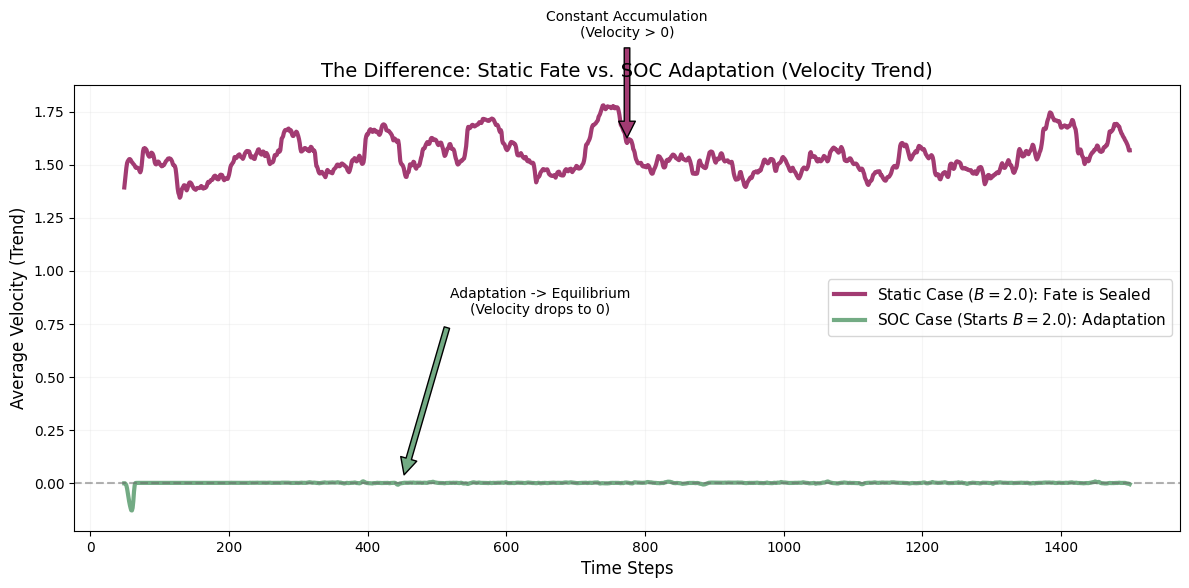

Generating System Breathing Plot...


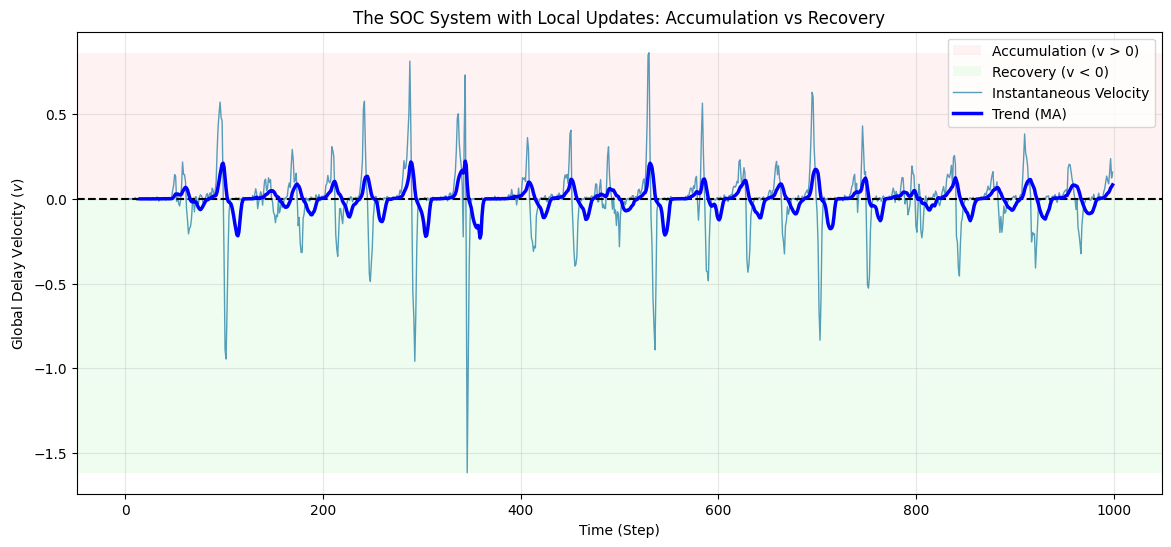

Generating Plot: Myopic vs Wise Comparison...


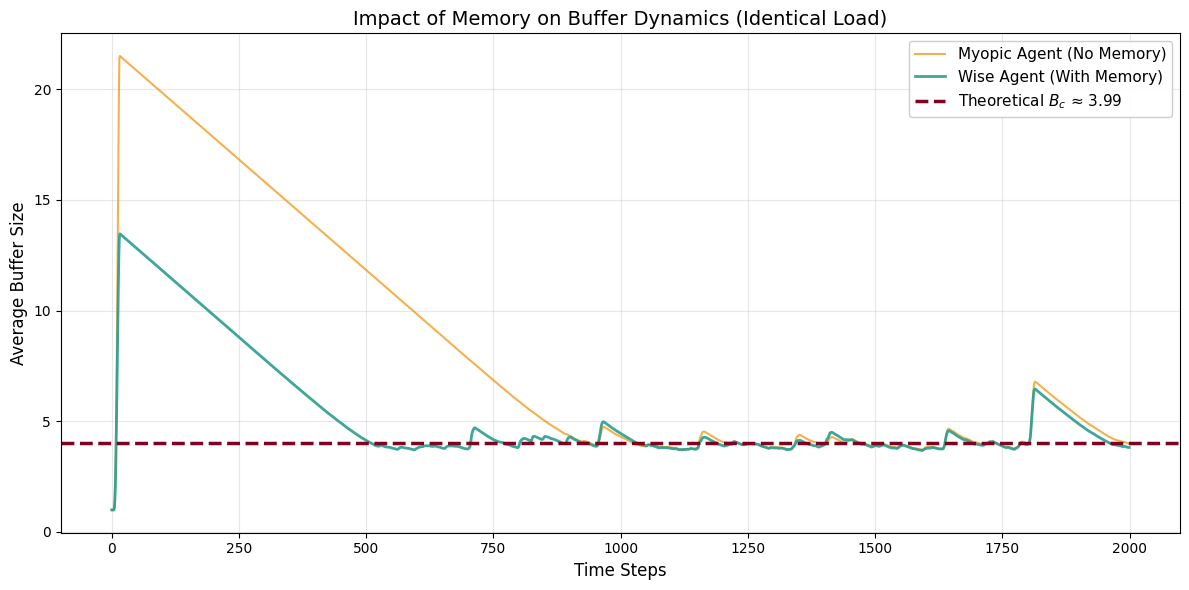

In [8]:
# 1. Plot the Single Run Comparison
plot_static_velocity_comparison()
plot_velocity_trend_comparison()
plot_system_breathing()
plot_single_run_comparison()



# 2. Plot the Ensemble Statistics
#plot_ensemble_wise()
# 1. Plot the Static Law
#plot_static_threshold()
#plot_static_velocity_over_time()    


# 2. Plot the Finite Size Effect
#plot_finite_size_scaling()

# 3. Plot the Dynamics (Myopic vs Wise)

# 4. Plot the System Breathing (Velocity)
